# Selections des features

# Modification de la résolution des données temporelles pour étudier l'influence de la précision du modèle de Machine Learning

# Précision du modèle pour tous les compteurs vélos de Paris

In [1]:
# Import library:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, ensemble, model_selection, preprocessing
from sklearn.tree import plot_tree
import time

# Définition du chemin d'accès:
%cd ..
%cd Datas

C:\Users\Home\Documents\ParisPyVelibTest\ParisPyVelib\Datas


## 1. Préparation des données

In [2]:
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

In [3]:
# Selection d'un seul compteur et uniquement pour l'année 2020
df = df[df.Address == "BD MAGENTA"]
df = df[df.Direction == "NO-SE"]
df = df[df.Y_Date_Count == 2020 ]

# Etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# Supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

# Vérification du nombre de jours
df['Datetime'].nunique()

8783

In [4]:
# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# Reset de l'index
df = df.reset_index(drop=True)

# Passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')

# Création d'un DataFrame temporaire df_t avec une selection de la fréquence en min
df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq='60min')])
          .agg({'Count_by_hour':'sum', 
                'Direction' : 'first', 
                'Latitude' : 'first',
                'Longitude' : 'first',
                'Y_Date_Count' : 'first', 
                'M_Date_Count' : 'first', 
                'D_Date_Count' : 'first', 
                'Dweek_Date_Count' : 'first',          
                'T°C' : 'mean',
                'Precip_last3h' : 'mean',
                'HR%' : 'mean',
                'High_ice' : 'mean', 
                'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first', 
                'nom_jour_ferie' : 'first', 
                'nom_vacances' : 'first', 
                'Confinement_id' : 'first', 
                'week_day_type' : 'first', 
                'AM_PM' : 'first'})).reset_index()

# suppression de la variable Datetime
df_t = df_t.drop('Datetime', axis = 1)

In [5]:
# List des variable catégorielle
cat_df = df_t.select_dtypes(include='object').columns.tolist()

# Transformation des variable catégorielle en variable indicatrices
df_t = pd.get_dummies(df_t, columns=cat_df)

In [6]:
# Selection de la target et des feats
target_t = df_t['Count_by_hour']
feats_t = df_t.drop(['Count_by_hour'], axis=1)

In [7]:
# Classification de la varibale Target
target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])

In [8]:
print(feats_t.shape)
print(target_t.shape)

(8783, 40)
(8783,)


# I. Selections des features

## 2. Machine Learning : modèle Random Forest avec 40 features

In [9]:
# Séparation du jeux de donnée pour entrainement
X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

# Preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = X_train
X_test_scaled = X_test

# Création d'un classifieur
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

parametres = {'max_features':[None], 'min_samples_split':list(range(2, 32, 2))}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                                             params  mean_test_score
0    {'max_features': None, 'min_samples_split': 2}         0.848704
1    {'max_features': None, 'min_samples_split': 4}         0.845431
2    {'max_features': None, 'min_samples_split': 6}         0.847566
3    {'max_features': None, 'min_samples_split': 8}         0.849843
4   {'max_features': None, 'min_samples_split': 10}         0.849559
5   {'max_features': None, 'min_samples_split': 12}         0.849274
6   {'max_features': None, 'min_samples_split': 14}         0.848705
7   {'max_features': None, 'min_samples_split': 16}         0.846569
8   {'max_features': None, 'min_samples_split': 18}         0.844293
9   {'max_features': None, 'min_samples_split': 20}         0.842585
10  {'max_features': None, 'min_samples_split': 22}         0.841019
11  {'max_features': None, 'min_samples_split': 24}         0.840592
12  {'max_features': None, 'min_samples_split': 26}         0.839596
13  {'max_features': None, 'min_sa

In [10]:
# Prédiction des features test et création de la matrice de confusion
clf = ensemble.RandomForestClassifier(min_samples_split=4)
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3
Classe réelle,,,,
0,423,37,0,0
1,37,352,55,0
2,0,35,335,58
3,0,0,34,391


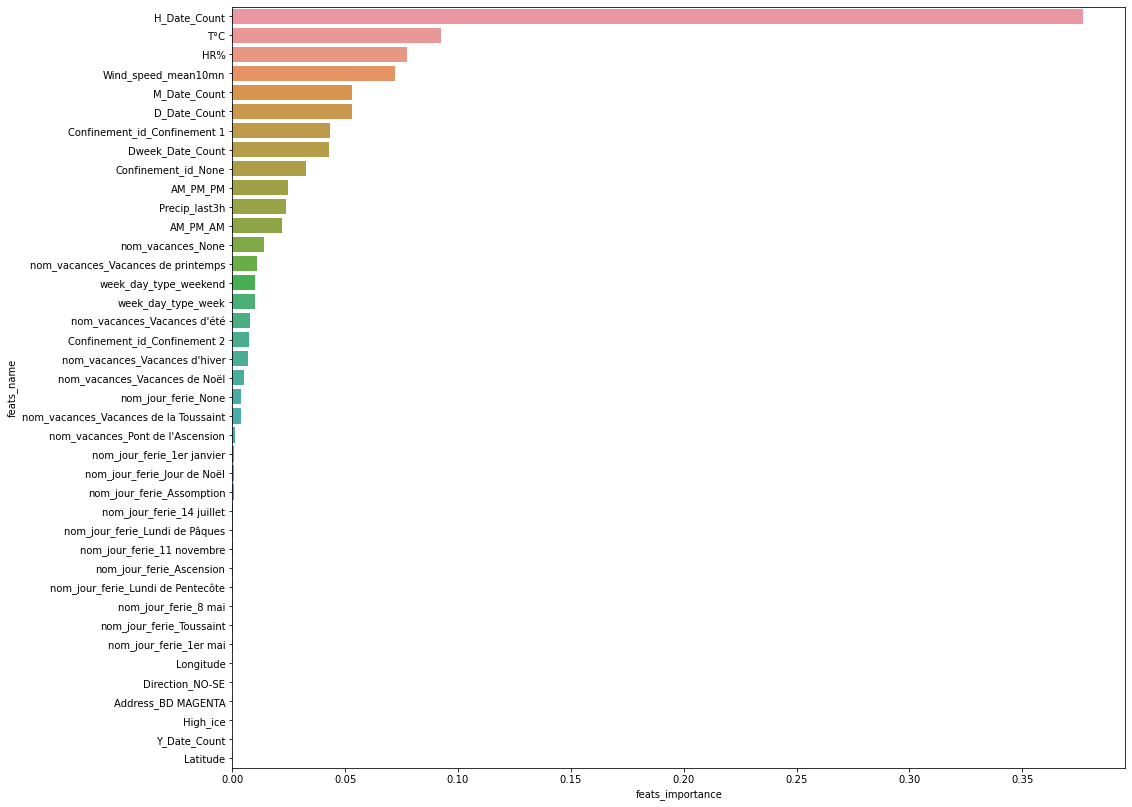

In [11]:
plt.figure(figsize=(16,14))

# Selection des noms et importance des features
feats_importance = clf.feature_importances_
feats_name = feats_t.columns.tolist()

# Transformation en dataframe
feats_importance = pd.DataFrame(feats_importance)
feats_importance = feats_importance.rename(columns={0:'feats_importance'})
feats_name = pd.DataFrame(feats_name)
feats_name = feats_name.rename(columns={0:'feats_name'})

# Concatenation des noms et importances des features puis trie décroissant
feats_values = pd.concat([feats_name, feats_importance], axis=1)
feats_values = feats_values.sort_values(by=['feats_importance'], ascending=False)

# Affichage des features selon leur importance
sns.barplot(x='feats_importance', y='feats_name', data=feats_values);

# ci dessous une solution plus rapide pour observer l'importance des features sans classement par ordre décroissant
# plt.barh(feats_t.head().columns.tolist(), clf.feature_importances_)

**Conclusion** : 

* On remarque que les features concernant les jours fériés sont négligeables dans le modèle. Il n'est donc pas nécessaire de garder toutes les features.

## 3. Diminution du nombre de features de 40 à 20

In [12]:
# Affichage de toutes les features
feats_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               8783 non-null   float64
 1   Longitude                              8783 non-null   float64
 2   Y_Date_Count                           8783 non-null   int64  
 3   M_Date_Count                           8783 non-null   int64  
 4   D_Date_Count                           8783 non-null   int64  
 5   Dweek_Date_Count                       8783 non-null   int64  
 6   T°C                                    8783 non-null   float64
 7   Precip_last3h                          8783 non-null   float64
 8   HR%                                    8783 non-null   float64
 9   High_ice                               8783 non-null   float64
 10  Wind_speed_mean10mn                    8783 non-null   float64
 11  H_Da

In [13]:
# Selectionne les 20 features première features qui sont pertinentes pour le modèle
feats_selected = feats_values['feats_name'][:20].values.tolist()
print(feats_selected)

['H_Date_Count', 'T°C', 'HR%', 'Wind_speed_mean10mn', 'M_Date_Count', 'D_Date_Count', 'Confinement_id_Confinement 1', 'Dweek_Date_Count', 'Confinement_id_None', 'AM_PM_PM', 'Precip_last3h', 'AM_PM_AM', 'nom_vacances_None', 'nom_vacances_Vacances de printemps', 'week_day_type_weekend', 'week_day_type_week', "nom_vacances_Vacances d'été", 'Confinement_id_Confinement 2', "nom_vacances_Vacances d'hiver", 'nom_vacances_Vacances de Noël']


In [14]:
# Création d'un nouveau tableau de features
feats_optimized = feats_t[feats_selected]
feats_optimized.shape

(8783, 20)

In [15]:
# Séparation du jeux de donnée pour entrainement
X_train, X_test, y_train, y_test = train_test_split(feats_optimized, target_t, test_size=0.2, random_state=101)

# Preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = X_train
X_test_scaled = X_test

# Création d'un classifieur
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

parametres = {'max_features':[None], 'min_samples_split':list(range(2, 32, 2))}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                                             params  mean_test_score
0    {'max_features': None, 'min_samples_split': 2}         0.847139
1    {'max_features': None, 'min_samples_split': 4}         0.850697
2    {'max_features': None, 'min_samples_split': 6}         0.849417
3    {'max_features': None, 'min_samples_split': 8}         0.848420
4   {'max_features': None, 'min_samples_split': 10}         0.848563
5   {'max_features': None, 'min_samples_split': 12}         0.848136
6   {'max_features': None, 'min_samples_split': 14}         0.846285
7   {'max_features': None, 'min_samples_split': 16}         0.845289
8   {'max_features': None, 'min_samples_split': 18}         0.842158
9   {'max_features': None, 'min_samples_split': 20}         0.837176
10  {'max_features': None, 'min_samples_split': 22}         0.838030
11  {'max_features': None, 'min_samples_split': 24}         0.836749
12  {'max_features': None, 'min_samples_split': 26}         0.835610
13  {'max_features': None, 'min_sa

In [16]:
# Prédiction des features test et création de la matrice de confusion

clf = ensemble.RandomForestClassifier(min_samples_split=4)
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3
Classe réelle,,,,
0,411,49,0,0
1,35,360,49,0
2,0,33,337,58
3,0,0,42,383


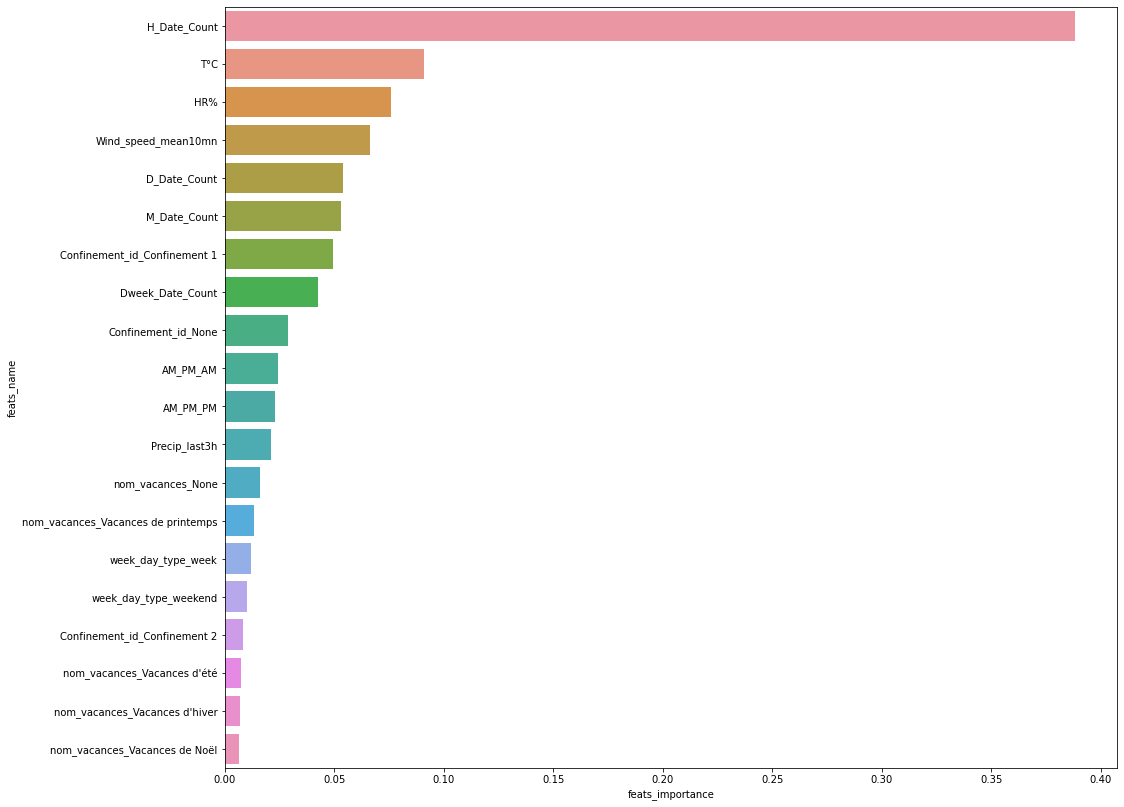

In [17]:
plt.figure(figsize=(16,14))

# selection des noms et importance des features
feats_importance = clf.feature_importances_
feats_name = feats_optimized.columns.tolist()

# transformation en dataframe
feats_importance = pd.DataFrame(feats_importance)
feats_importance = feats_importance.rename(columns={0:'feats_importance'})
feats_name = pd.DataFrame(feats_name)
feats_name = feats_name.rename(columns={0:'feats_name'})

# concatenation des noms et importances des features puis trie décroissant
feats_values = pd.concat([feats_name, feats_importance], axis=1)
feats_values = feats_values.sort_values(by=['feats_importance'], ascending=False)

# affichage des features selon leur importance
sns.barplot(x='feats_importance', y='feats_name', data=feats_values);

In [18]:
# calcul de la somme des features
print("la somme totale des features selectionné est de :", feats_importance['feats_importance'].sum().round())

la somme totale des features selectionné est de : 1.0


**Conclusion :** 

* La diminution du nombre de features n'a pas d'impact sur la performance du modèle.

## 4. Profondeur de l'arbre du modèle Random Forest

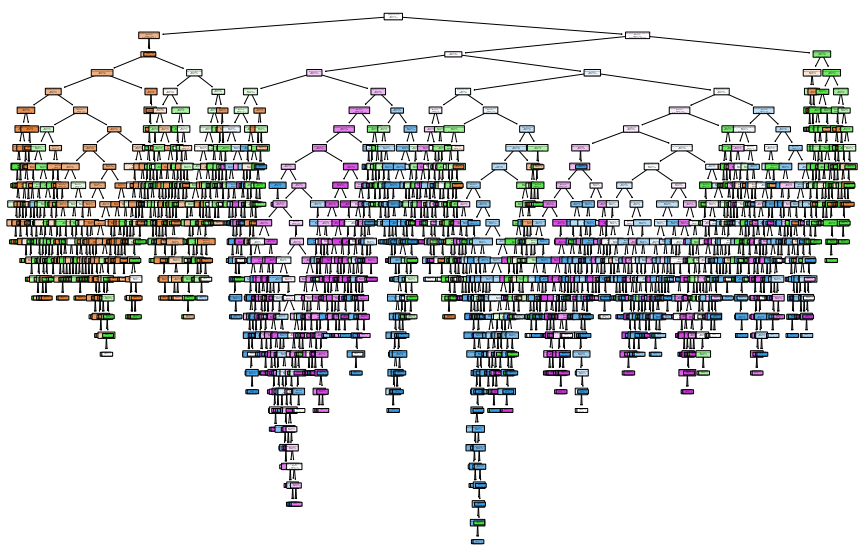

In [19]:
# affichage de l'arbre
fig = plt.figure(figsize=(15, 10))
plot_tree(clf.estimators_[0], 
          feature_names=feats_optimized.columns.to_list(),
          class_names=None, 
          filled=True, impurity=True, 
          rounded=True);

In [20]:
print("la profondeur de l'arbre est de :", clf.estimators_[0].tree_.max_depth)

la profondeur de l'arbre est de : 28


**Commentaire(s) :**

* La profondeur de l'arbre est beaucoup trop grande pour être lisible. On recommence le fit avec une profondeur max de 3 pour que l'arbre soit lisible

In [21]:
# Prédiction des features test et création de la matrice de confusion

clf = ensemble.RandomForestClassifier(min_samples_split=4, max_depth=3)
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3
Classe réelle,,,,
0,411,49,0,0
1,35,360,49,0
2,0,33,337,58
3,0,0,42,383


In [22]:
print('Le modèle fournit une précision de :',clf.score(X_test, y_test))

Le modèle fournit une précision de : 0.6260671599317018


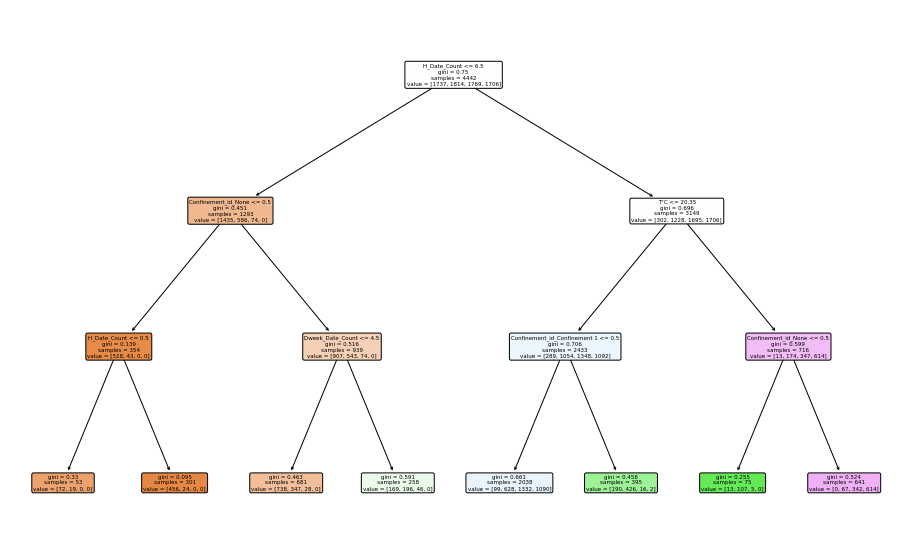

In [23]:
# affichage de l'arbre
plt.figure(figsize=(16, 10))
plot_tree(clf.estimators_[0], 
          feature_names=feats_optimized.columns.to_list(),
          class_names=None, 
          filled=True, impurity=True, 
          rounded=True);

**Commentaires :**

* Le modèle fournit une précision moindre pour une profondeur de 3, toutefois il est plus lisible.

# II. Modification de la résolution des données temporelles pour étudier l'influence de la précision du modèle de Machine Learning

## 5. Influence de la résolution temporelle

La résolution de 60min fournit une précision de : 0.8511248690158599
La résolution de 120min fournit une précision de : 0.8485651643546379
La résolution de 180min fournit une précision de : 0.8300530315455689
La résolution de 240min fournit une précision de : 0.8303014115514117
La résolution de 360min fournit une précision de : 0.7899254409892708
La résolution de 720min fournit une précision de : 0.7931623931623931
La résolution de B fournit une précision de : 0.7607433217189314
La résolution de D fournit une précision de : 0.719520748100526
La résolution de W fournit une précision de : 0.5027777777777778
le temps de traitement est de :  400.78578901290894  s


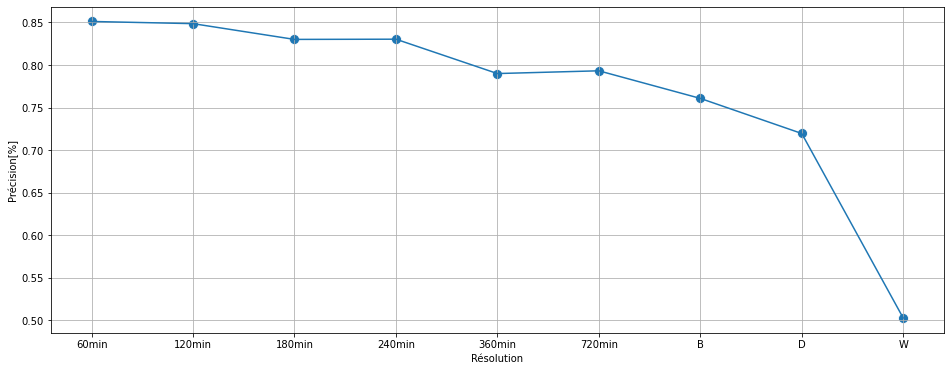

In [24]:
# début timer
start = time.time()

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')


# liste résolution temporelle et résultat de précision
resolution_temp = ['60min', '120min', '180min', '240min', '360min', '720min', 
                   'B', # jours de travail   
                   'D', # jour
                   'W'] # semaine
precision = []


# création d'un DataFrame temporaire df_t avec une selection de la fréquence en min
for resolution in resolution_temp:
    
    df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq=resolution)])
              .agg({'Count_by_hour':'sum', 
                    'Direction' : 'first', 
                    'Latitude' : 'first',
                    'Longitude' : 'first',
                    'Y_Date_Count' : 'first', 
                    'M_Date_Count' : 'first', 
                    'D_Date_Count' : 'first', 
                    'Dweek_Date_Count' : 'first',          
                    'T°C' : 'mean',
                    'Precip_last3h' : 'mean',
                    'HR%' : 'mean',
                    'High_ice' : 'mean', 
                    'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first',
                    'nom_vacances' : 'first', 
                    'Confinement_id' : 'first', 
                    'week_day_type' : 'first', 
                    'AM_PM' : 'first'})).reset_index()
    
    # suppression de la variable Datetime
    df_t = df_t.drop('Datetime', axis = 1)
    
    # list des variable catégorielle
    cat_t = df_t.select_dtypes(include='object').columns.tolist()

    # Transformation des variable catégorielle en variable indicatrices
    df_t = pd.get_dummies(df_t, columns=cat_t)
    
    # selection de la target et des feats
    target_t = df_t['Count_by_hour']
    feats_t = df_t.drop(['Count_by_hour'], axis=1)
    
    target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])
    
    # Séparation du jeux de donnée pour entrainement
    X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

    # preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Création d'un classifieur
    clf = ensemble.RandomForestClassifier()
    clf.fit(X_train_scaled, y_train)

    parametres = {'max_features':[None], 'min_samples_split':list(range(2, 32, 2))}

    grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

    grille = grid_clf.fit(X_train_scaled,y_train)
    
    print("La résolution de", resolution, "fournit une précision de :", grid_clf.best_score_)
    
    precision.append(grid_clf.best_score_)


end = time.time()
print("le temps de traitement est de : ", (end - start), " s")

plt.figure(figsize=(16,6))
plt.xlabel('Résolution')
plt.ylabel('Précision[%]')
plt.grid('--')
sns.lineplot(x=resolution_temp, y=precision)
sns.scatterplot(x=resolution_temp, y=precision, s=100);

**Conclusion** : La résolution donnant la meilleure précision est 120mn et 60mn

## 6. Utilisation d'un modèle non ML

D'après le modèle Random Forest ainsi que l'étude statistique réalisé (voir Notebook3_PreProcessing_ModeleML) on sait que le nombre de vélos est fonction des paramètres suivants : 

* matin ou aprés-midi
* jour de semaine ou weekend
* La météo
* Le premier confinement due au Covid19
* vacances scolaires
* etc.

Le but de cette étude est de créer un modèle de prédiction basé uniquement sur la **valeur moyenne** de passage de vélo en fonction des paramètres suivants : jours de semaine ou weekend ET matin ou aprés-midi

Les performances de ce modèle seront à comparé avec les résultats obtenus avec le modèle Random Forest

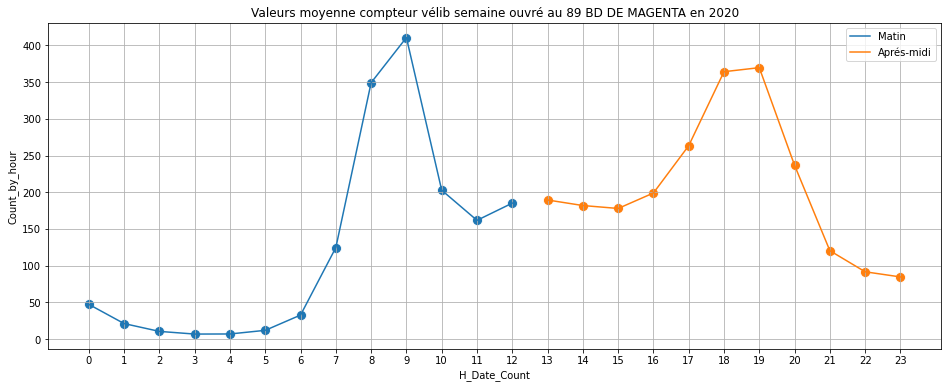

In [25]:
# Séparation des données pour calcul moyenne uniquement en semaine matin et aprés midi
df_AM = df[(df.AM_PM == "AM") & (df.week_day_type == "week")]
df_PM = df[(df.AM_PM == "PM") & (df.week_day_type == "week")]

# Calcul valeur moyenne pour chaque jour de la semaine sur l'année 2020
df_AM = df_AM.groupby(['Dweek_Date_Count', pd.Grouper(key='H_Date_Count')]).agg({'Count_by_hour' : 'mean'}).reset_index()
df_PM = df_PM.groupby(['Dweek_Date_Count', pd.Grouper(key='H_Date_Count')]).agg({'Count_by_hour' : 'mean'}).reset_index()

# Calcul valeur moyenne pour tous les jours de la semaine
df_AM_week = df_AM.groupby('H_Date_Count').agg({'Count_by_hour' : 'mean'}).reset_index()
df_PM_week = df_PM.groupby('H_Date_Count').agg({'Count_by_hour' : 'mean'}).reset_index()

# Affichage de la forme de référence pour AM et PM
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_AM_week)
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_AM_week, label='Matin')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_PM_week)
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_PM_week, label='Aprés-midi')
plt.xticks(np.arange(0, 24, 1))
plt.title('Valeurs moyenne compteur vélib semaine ouvré au 89 BD DE MAGENTA en 2020')
plt.grid('--');

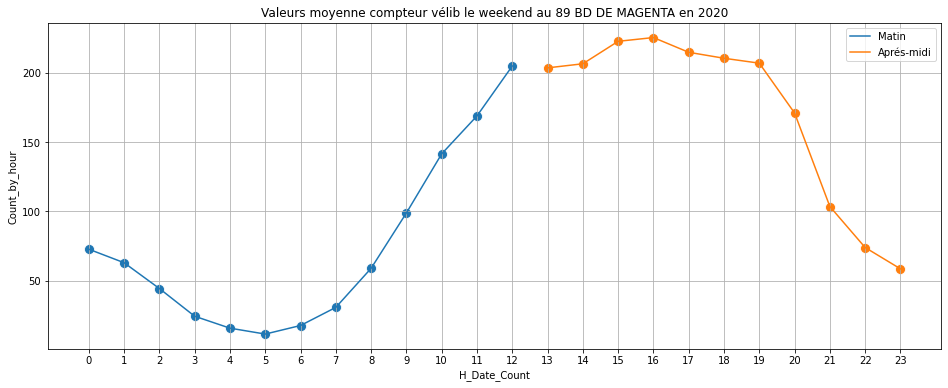

In [26]:
# Séparation des données pour calcul moyenne uniquement le weekend matin et aprés midi
df_AM = df[(df.AM_PM == "AM") & (df.week_day_type == "weekend")]
df_PM = df[(df.AM_PM == "PM") & (df.week_day_type == "weekend")]

# Calcul valeur moyenne pour chaque weekend sur l'année 2020
df_AM = df_AM.groupby(['Dweek_Date_Count', pd.Grouper(key='H_Date_Count')]).agg({'Count_by_hour' : 'mean'}).reset_index()
df_PM = df_PM.groupby(['Dweek_Date_Count', pd.Grouper(key='H_Date_Count')]).agg({'Count_by_hour' : 'mean'}).reset_index()

# Calcul valeur moyenne pour tous les weekend sur l'année 2020
df_AM_weekend = df_AM.groupby('H_Date_Count').agg({'Count_by_hour' : 'mean'}).reset_index()
df_PM_weekend = df_PM.groupby('H_Date_Count').agg({'Count_by_hour' : 'mean'}).reset_index()

# Affichage de la forme de référence pour AM et PM
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_AM_weekend)
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_AM_weekend, label='Matin')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_PM_weekend)
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_PM_weekend, label='Aprés-midi')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.title('Valeurs moyenne compteur vélib le weekend au 89 BD DE MAGENTA en 2020')
plt.grid('--');

**Commentaires** :

Prenons comme "modèle" ces quatre courbes de fréquences de comptage de vélo pour le compteur 89 BD DE MAGENTA, et essayons de tester les performances de ce modèle pour les 5 premiers mois de l'année 2021. C'est un peu comme si notre l'entrainement des données était réalisé sur l'année 2020 et le test sur l'année 2021

In [27]:
# Chargement et préparation des données
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

# Selection d'un seul compteur et uniquement pour l'année 2020
df = df[df.Address == "BD MAGENTA"]
df = df[df.Direction == "NO-SE"]
df = df[df.Y_Date_Count == 2021 ]

# Etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# Supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# Reset de l'index
df = df.reset_index(drop=True)

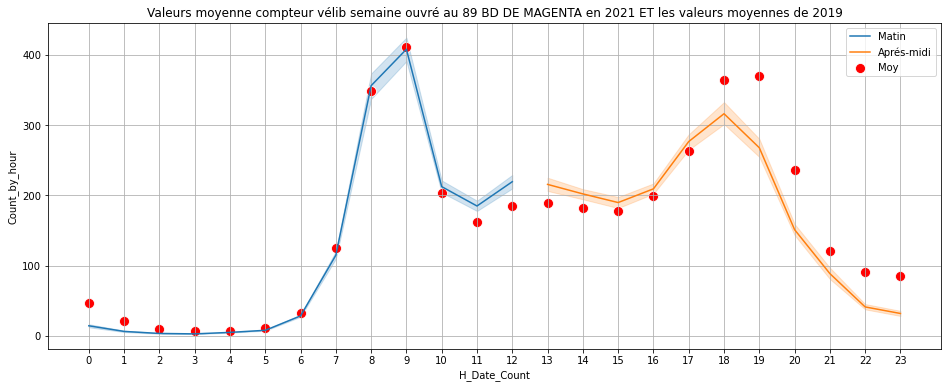

In [28]:
# Séparation des données pour calcul moyenne uniquement en semaine ouvré matin et aprés midi
df_AM_2021 = df[(df.AM_PM == "AM") & (df.week_day_type == "week")]
df_PM_2021 = df[(df.AM_PM == "PM") & (df.week_day_type == "week")]

plt.figure(figsize=(16,6))

# Affichage des données pour le matin en 2021 ET les prédiction en rouge
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_AM_2021, label='Matin')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_AM_week, color='r', label='Moy')

# Affichage des données pour l'aprés-midi en 2021 ET les prédiction en rouge
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_PM_2021, label='Aprés-midi')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_PM_week, color='r')
plt.xticks(np.arange(0, 24, 1))
plt.title('Valeurs moyenne compteur vélib semaine ouvré au 89 BD DE MAGENTA en 2021 ET les valeurs moyennes de 2019')
plt.grid('--');

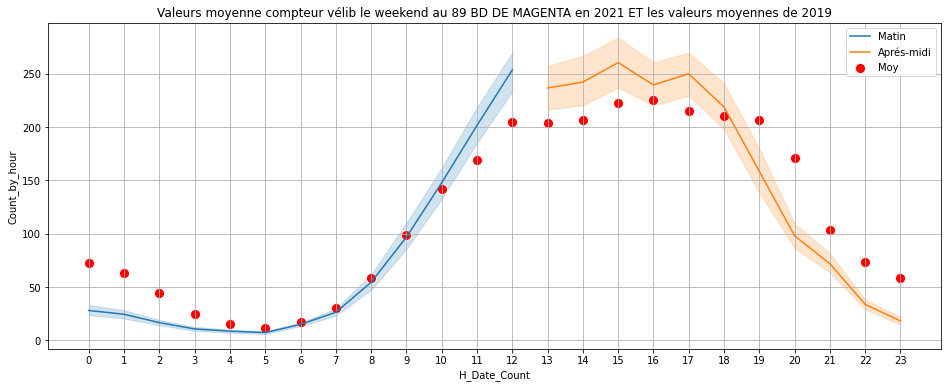

In [29]:
# Séparation des données pour calcul moyenne uniquement en weekend matin et aprés midi
df_AM_2021_weekend = df[(df.AM_PM == "AM") & (df.week_day_type == "weekend")]
df_PM_2021_weekend = df[(df.AM_PM == "PM") & (df.week_day_type == "weekend")]

plt.figure(figsize=(16,6))

# Affichage des données pour le matin en 2021 ET les prédiction en rouge
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_AM_2021_weekend, label='Matin')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_AM_weekend, color='r', label='Moy')

# Affichage des données pour l'aprés-midi en 2021 ET les prédiction en rouge
sns.lineplot(x='H_Date_Count', y='Count_by_hour', data=df_PM_2021_weekend, label='Aprés-midi')
sns.scatterplot(x='H_Date_Count', y='Count_by_hour', s=100, data=df_PM_weekend, color='r')
plt.xticks(np.arange(0, 24, 1))
plt.title('Valeurs moyenne compteur vélib le weekend au 89 BD DE MAGENTA en 2021 ET les valeurs moyennes de 2019')
plt.grid('--');

**Commentaires :**

Concernant le compteur 89 BD DE MAGENTA les valeurs moyenne de comptage de vélo de 2020 semble suivre la même tendance en 2021. On remarque qu'entre minuit et 2h du matin les valeurs moyennes sont trop hautes. En outre on retrouve cette tendance aussi après 19h.

Enfin, de manière globale la tendance semble rester la même entre 2020 et 2021 et les proportions totales sur une journée aussi. Toutefois ce résultat est valable uniquement pour le compteur 89 BD DE MAGENTA.

Maintenant essayons de créer un critère de précision en calculant par exemple le ratio de vélo compter par demi-journée en 2021 sur la moyenne des vélos compter en 2020 et essayons de faire mieux que 85% de précision c'est-à-dire une erreur de **15% max**.

In [30]:
# Changement nom de la colonne Count_by_hour
df_AM_week = df_AM_week.rename(columns={"Count_by_hour" : "Count_by_hour_AM_weekend"})
df_PM_week = df_PM_week.rename(columns={"Count_by_hour" : "Count_by_hour_AM_weekend"})
df_AM_weekend = df_AM_weekend.rename(columns={"Count_by_hour" : "Count_by_hour_AM_weekend"})
df_PM_weekend = df_PM_weekend.rename(columns={"Count_by_hour" : "Count_by_hour_AM_weekend"})

# Fusion des données et calcul du ratio pour AM et week
result_AM_week = pd.merge(df_AM_week, df_AM_2021, on="H_Date_Count")
result_AM_week = result_AM_week[['H_Date_Count', 'Count_by_hour_AM_weekend', 'Count_by_hour', 'M_Date_Count', 'Datetime']]
result_AM_week['ratio'] = result_AM_week.Count_by_hour_AM_weekend / result_AM_week.Count_by_hour

# Fusion des données et calcul du ratio pour PM et week
result_PM_week = pd.merge(df_PM_week, df_PM_2021, on="H_Date_Count")
result_PM_week = result_PM_week[['H_Date_Count', 'Count_by_hour_AM_weekend', 'Count_by_hour', 'M_Date_Count', 'Datetime']]
result_PM_week['ratio'] = result_PM_week.Count_by_hour_AM_weekend / result_PM_week.Count_by_hour

# Fusion des données et calcul du ratio pour AM et weekend
result_AM_weekend = pd.merge(df_AM_weekend, df_AM_2021_weekend, on="H_Date_Count")
result_AM_weekend = result_AM_weekend[['H_Date_Count', 'Count_by_hour_AM_weekend', 'Count_by_hour', 'M_Date_Count', 'Datetime']]
result_AM_weekend['ratio'] = result_AM_weekend.Count_by_hour_AM_weekend / result_AM_weekend.Count_by_hour

# Fusion des données et calcul du ratio pour AM et weekend
result_PM_weekend = pd.merge(df_PM_weekend, df_PM_2021_weekend, on="H_Date_Count")
result_PM_weekend = result_PM_weekend[['H_Date_Count', 'Count_by_hour_AM_weekend', 'Count_by_hour', 'M_Date_Count', 'Datetime']]
result_PM_weekend['ratio'] = result_PM_weekend.Count_by_hour_AM_weekend / result_PM_weekend.Count_by_hour

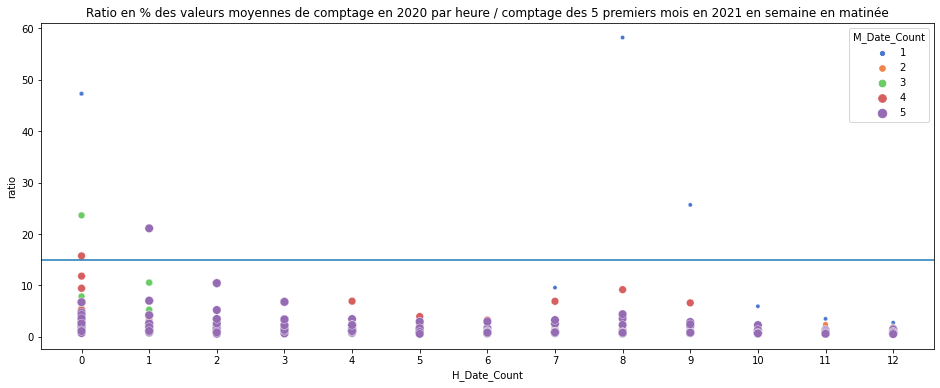

In [31]:
# Affichage des ratio par heure pour le matin en semaine et pour les cinq premier mois de l'années 2021
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='ratio', size ='M_Date_Count', hue ='M_Date_Count', palette="muted", 
                data=result_AM_week)
plt.axhline(15)
plt.xticks(np.arange(0, 13, 1))
plt.title("Ratio en % des valeurs moyennes de comptage en 2020 par heure / comptage des 5 premiers mois en "
          "2021 en semaine en matinée");

In [32]:
print("Nombre de valeurs au dessus de 15% :", result_AM_week[result_AM_week.ratio > 15].shape[0], 
      "/", result_AM_week.shape[0])

Nombre de valeurs au dessus de 15% : 44 / 1378


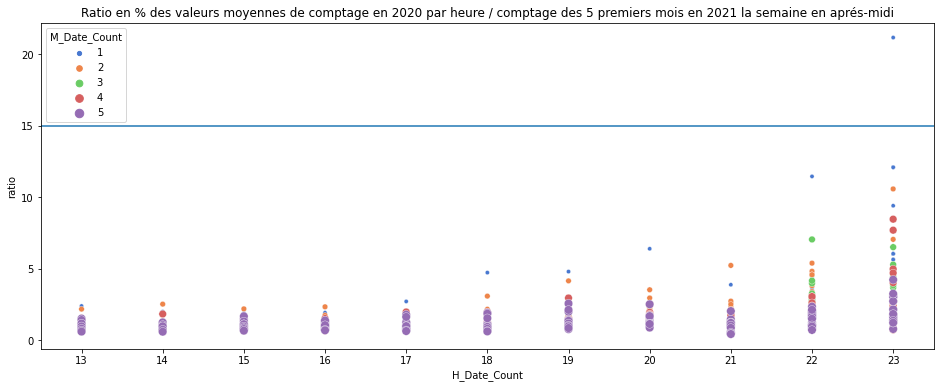

In [33]:
# Affichage des ratio par heure pour le matin en semaine et pour les cinq premier mois de l'années 2021
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='ratio', size ='M_Date_Count', hue ='M_Date_Count', palette="muted", 
                data=result_PM_week)
plt.axhline(15)
plt.xticks(np.arange(13, 24, 1))
plt.title("Ratio en % des valeurs moyennes de comptage en 2020 par heure / comptage des 5 premiers mois en "
          "2021 la semaine en aprés-midi");

In [34]:
print("Nombre de valeurs au dessus de 15% :", result_PM_week[result_PM_week.ratio > 15].shape[0], 
      "/", result_PM_week.shape[0])

Nombre de valeurs au dessus de 15% : 1 / 1166


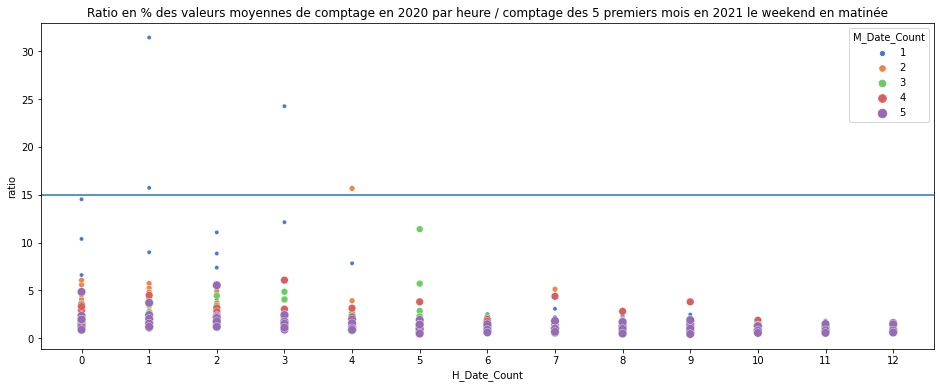

In [35]:
# Affichage des ratio par heure pour le matin et le weekend et pour les cinq premier mois de l'années 2021
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='ratio', size ='M_Date_Count', hue ='M_Date_Count', palette="muted", 
                data=result_AM_weekend)
plt.axhline(15)
plt.xticks(np.arange(0, 13, 1))
plt.title("Ratio en % des valeurs moyennes de comptage en 2020 par heure / comptage des 5 premiers mois en "
          "2021 le weekend en matinée");

In [36]:
print("Nombre de valeurs au dessus de 15% :", result_AM_weekend[result_AM_weekend.ratio > 15].shape[0],
      "/", result_AM_weekend.shape[0])

Nombre de valeurs au dessus de 15% : 7 / 558


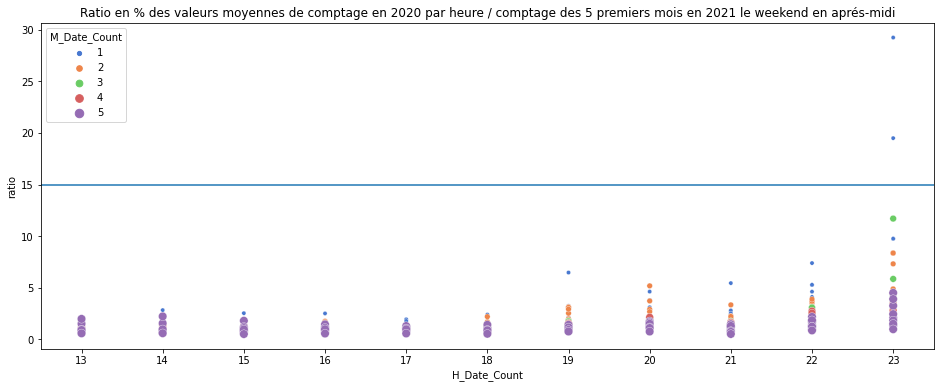

In [37]:
# Affichage des ratio par heure pour le matin et le weekend et pour les cinq premier mois de l'années 2021
plt.figure(figsize=(16,6))
sns.scatterplot(x='H_Date_Count', y='ratio', size ='M_Date_Count', hue ='M_Date_Count', palette="muted", 
                data=result_PM_weekend)
plt.axhline(15)
plt.xticks(np.arange(13, 24, 1))
plt.title("Ratio en % des valeurs moyennes de comptage en 2020 par heure / comptage des 5 premiers mois en "
          "2021 le weekend en aprés-midi");

In [38]:
print("Nombre de valeurs au dessus de 15% :", result_PM_weekend[result_PM_weekend.ratio > 15].shape[0],
      "/", result_PM_weekend.shape[0])

Nombre de valeurs au dessus de 15% : 2 / 473


**Commentaires** :

On observe que le modèle de la moyenne calculé sur 2020 donne des erreurs de plus de 15% les jours en semaine et en matinée pour le mois de janvier, mars, arvil et mai, pour 44 valeurs / 1378 au total (soit 3.2%)

Cependant, pour l'aprés midi en semaine, le matin et l'aprés-midi en weekend les résultats sont trés satisfaisants car l'erreur reste en dessous de 15% pour une part négligeable de valeurs de la variable H_Date_Count.

On peut donc considérer que ce modèle n'est pas aussi performant que le modèle Random Forest car très dépendant de la base d'entrainement, mais aussi il ne prend pas en compte les variables multiples tels que la météo, le confinement, les événements propre à la ville de Paris, etc. 

Toutefois, cela reste une bonne approximation qui reste trés facilement interprétable.

## Conclusion : 

L'objectif de cette étude est triple :

* Selectionné les features pertinentes pour en réduire le nombre et optimiser le temps de traitement du modèle de machine Learning
* Quel est l'impact de la résolution temporelle sur la précision de modèle de machine learning selectionner
* Comparé la performance d'un modèle statistique simple avec le modèle Random Forest

1. Le nombre de features **peut être réduit à 21 au lieu de 40**, 
2. **la meilleure résolution temporelle reste 60mn ou 120mn** ce qui ne demandera pas de modification du dataset. Enfin, la profondeur du modèle Random Forest a été optimisée pour un seul compteur. Toutefois, il faut rester prudent car cela est vrai uniquement pour le compteur "89 BD DE MAGENTA" . Des tests supplementaires pour sélectionner la profondeur de l'arbre pour optimum pour tous les compteurs sont conseillés.
3. un modèle de prédiction simple basée sur une valeur moyenne reste un bonne approximation mais peu parfois pour certaines dates et période de la journée présenté des erreurs supérieures au modèle Random Forest.

# III. Précision du modèle pour tous les compteurs vélos de Paris

In [39]:
# Chargement des données
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

# Etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# Supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

In [40]:
# Création liste d'address pour chaque compteur
address = df['Address'].unique().tolist()

In [41]:
# Paramètres de l'affichage des graphiques
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

le temps de traitement est de :  4.0 mn et 33.01 secondes


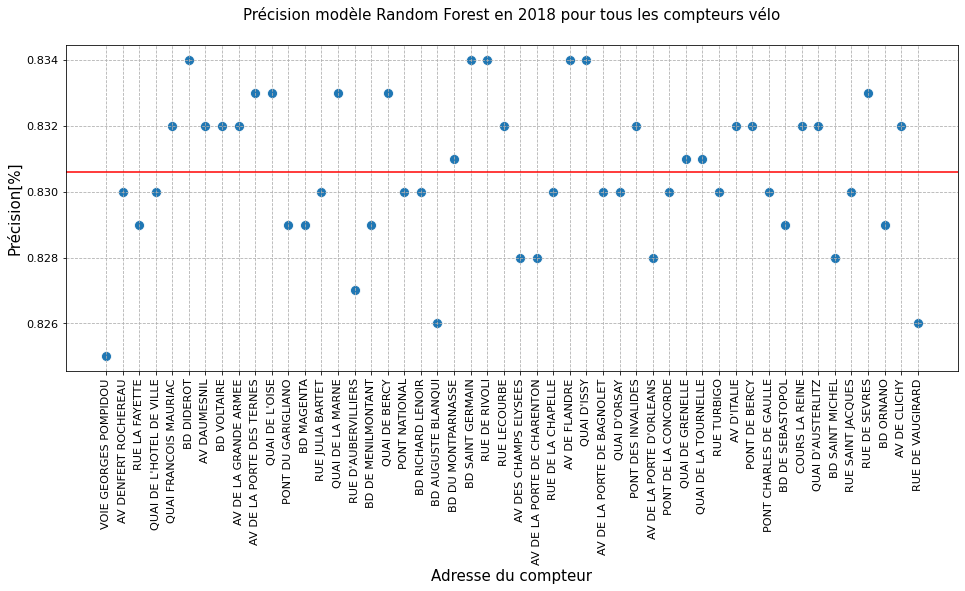

In [42]:
#2018

# selection de l'année
df = df[df.Y_Date_Count == 2018 ]

# début timer
start = time.time()

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')

# création liste contenant les scores à calculé
precision = []

# création d'un DataFrame temporaire df_t avec une selection de la fréquence en min  
for compteur in address:
    
    df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq='120min')])
              .agg({'Count_by_hour':'sum', 
                    'Direction' : 'first', 
                    'Latitude' : 'first',
                    'Longitude' : 'first',
                    'Y_Date_Count' : 'first', 
                    'M_Date_Count' : 'first', 
                    'D_Date_Count' : 'first', 
                    'Dweek_Date_Count' : 'first',          
                    'T°C' : 'mean',
                    'Precip_last3h' : 'mean',
                    'HR%' : 'mean',
                    'High_ice' : 'mean', 
                    'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first',
                    'nom_vacances' : 'first', 
                    'Confinement_id' : 'first', 
                    'week_day_type' : 'first', 
                    'AM_PM' : 'first'})).reset_index()

    # suppression de la variable Datetime
    df_t = df_t.drop('Datetime', axis = 1)

    # list des variable catégorielle
    cat_t = df_t.select_dtypes(include='object').columns.tolist()

    # Transformation des variable catégorielle en variable indicatrices
    df_t = pd.get_dummies(df_t, columns=cat_t)

    # selection de la target et des feats
    target_t = df_t['Count_by_hour']
    feats_t = df_t.drop(['Count_by_hour'], axis=1)

    target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])

    # Séparation du jeux de donnée pour entrainement
    X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

    # preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Création d'un classifieur avec une profondeur de l'arbre = 19
    clf = ensemble.RandomForestClassifier(min_samples_split=4, max_depth = 19)
    clf.fit(X_train_scaled, y_train)
    
    # ajout des valeurs de précisions
    precision.append(clf.score(X_test, y_test).round(3))

# fin du compteur de temps
end = time.time()
print("le temps de traitement est de : ", 
      np.array((end - start) // 60).round(0), 
      "mn et", np.array(((end - start) / 60 - (end - start) // 60)*60).round(2), 
      "secondes")

# affichage des compteurs en fonction de la précision
plt.figure(figsize=(16,6))
plt.xlabel('Adresse du compteur')
plt.xticks(rotation=90)
plt.ylabel('Précision[%]')
plt.grid(linestyle='--')
plt.title('Précision modèle Random Forest en 2018 pour tous les compteurs vélo')
plt.axhline(np.array(precision).mean(), color='r')
sns.scatterplot(x=address, y=precision, s=100);

le temps de traitement est de :  14.0 mn et 59.13 secondes


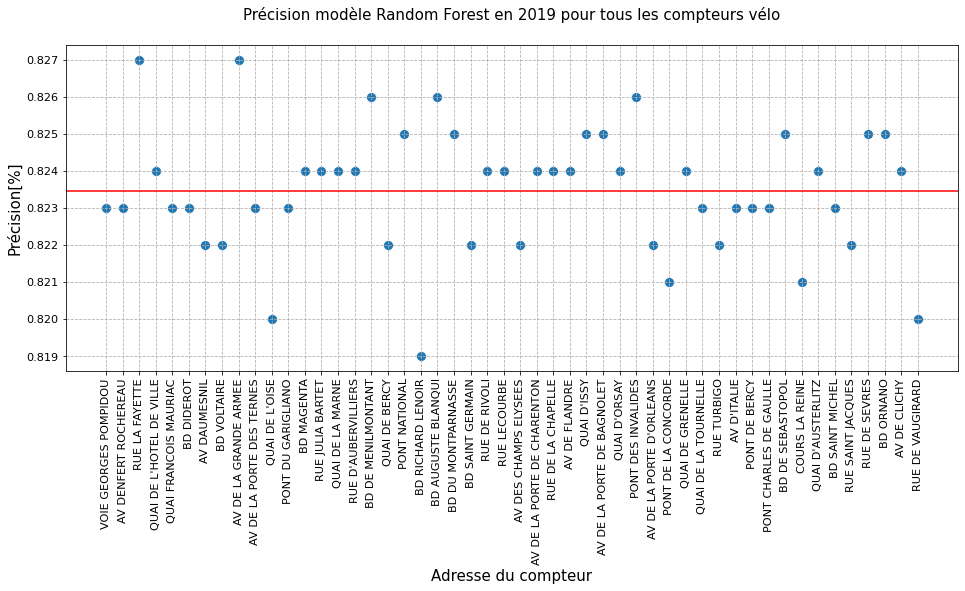

In [43]:
# 2019

# chargement des données
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

# etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

# selection de l'année
df = df[df.Y_Date_Count == 2019 ]

# début timer
start = time.time()

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')

# création liste contenant les scores à calculé
precision = []

# création d'un DataFrame temporaire df_t avec une selection de la fréquence en min  
for compteur in address:
    
    df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq='120min')])
              .agg({'Count_by_hour':'sum', 
                    'Direction' : 'first', 
                    'Latitude' : 'first',
                    'Longitude' : 'first',
                    'Y_Date_Count' : 'first', 
                    'M_Date_Count' : 'first', 
                    'D_Date_Count' : 'first', 
                    'Dweek_Date_Count' : 'first',          
                    'T°C' : 'mean',
                    'Precip_last3h' : 'mean',
                    'HR%' : 'mean',
                    'High_ice' : 'mean', 
                    'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first',
                    'nom_vacances' : 'first', 
                    'Confinement_id' : 'first', 
                    'week_day_type' : 'first', 
                    'AM_PM' : 'first'})).reset_index()

    # suppression de la variable Datetime
    df_t = df_t.drop('Datetime', axis = 1)

    # list des variable catégorielle
    cat_t = df_t.select_dtypes(include='object').columns.tolist()

    # Transformation des variable catégorielle en variable indicatrices
    df_t = pd.get_dummies(df_t, columns=cat_t)

    # selection de la target et des feats
    target_t = df_t['Count_by_hour']
    feats_t = df_t.drop(['Count_by_hour'], axis=1)

    target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])

    # Séparation du jeux de donnée pour entrainement
    X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

    # preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Création d'un classifieur avec une profondeur de l'arbre = 19
    clf = ensemble.RandomForestClassifier(min_samples_split=4, max_depth = 19)
    clf.fit(X_train_scaled, y_train)
    
    # ajout des valeurs de précisions
    precision.append(clf.score(X_test, y_test).round(3))

# fin du compteur de temps
end = time.time()
print("le temps de traitement est de : ", 
      np.array((end - start) // 60).round(0), 
      "mn et", np.array(((end - start) / 60 - (end - start) // 60)*60).round(2), 
      "secondes")

# affichage des compteurs en fonction de la précision
plt.figure(figsize=(16,6))
plt.xlabel('Adresse du compteur')
plt.xticks(rotation=90)
plt.ylabel('Précision[%]')
plt.grid(linestyle='--')
plt.title('Précision modèle Random Forest en 2019 pour tous les compteurs vélo')
plt.axhline(np.array(precision).mean(), color='r')
sns.scatterplot(x=address, y=precision, s=100);

le temps de traitement est de :  34.0 mn et 28.67 secondes


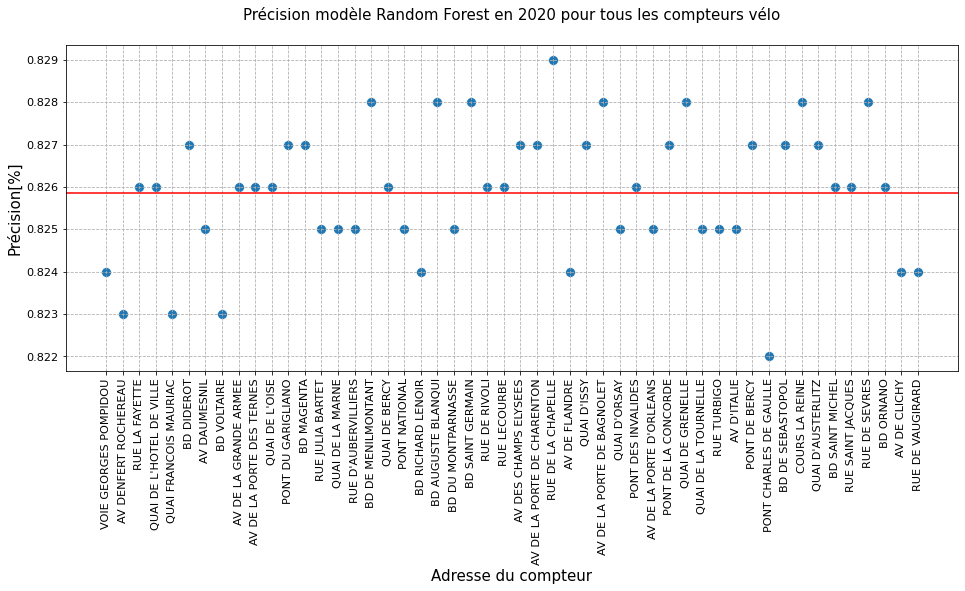

In [44]:
# 2020

# chargement des données
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

# etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

# selection de l'année
df = df[df.Y_Date_Count == 2020 ]

# début timer
start = time.time()

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')

# création liste contenant les scores à calculé
precision = []

# création d'un DataFrame temporaire df_t avec une selection de la fréquence en min  
for compteur in address:
    
    df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq='120min')])
              .agg({'Count_by_hour':'sum', 
                    'Direction' : 'first', 
                    'Latitude' : 'first',
                    'Longitude' : 'first',
                    'Y_Date_Count' : 'first', 
                    'M_Date_Count' : 'first', 
                    'D_Date_Count' : 'first', 
                    'Dweek_Date_Count' : 'first',          
                    'T°C' : 'mean',
                    'Precip_last3h' : 'mean',
                    'HR%' : 'mean',
                    'High_ice' : 'mean', 
                    'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first',
                    'nom_vacances' : 'first', 
                    'Confinement_id' : 'first', 
                    'week_day_type' : 'first', 
                    'AM_PM' : 'first'})).reset_index()

    # suppression de la variable Datetime
    df_t = df_t.drop('Datetime', axis = 1)

    # list des variable catégorielle
    cat_t = df_t.select_dtypes(include='object').columns.tolist()

    # Transformation des variable catégorielle en variable indicatrices
    df_t = pd.get_dummies(df_t, columns=cat_t)

    # selection de la target et des feats
    target_t = df_t['Count_by_hour']
    feats_t = df_t.drop(['Count_by_hour'], axis=1)

    target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])

    # Séparation du jeux de donnée pour entrainement
    X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

    # preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Création d'un classifieur avec une profondeur de l'arbre = 19
    clf = ensemble.RandomForestClassifier(min_samples_split=4, max_depth = 19)
    clf.fit(X_train_scaled, y_train)
    
    # ajout des valeurs de précisions
    precision.append(clf.score(X_test, y_test).round(3))

# fin du compteur de temps
end = time.time()
print("le temps de traitement est de : ", 
      np.array((end - start) // 60).round(0), 
      "mn et", np.array(((end - start) / 60 - (end - start) // 60)*60).round(2), 
      "secondes")

# affichage des compteurs en fonction de la précision
plt.figure(figsize=(16,6))
plt.xlabel('Adresse du compteur')
plt.xticks(rotation=90)
plt.ylabel('Précision[%]')
plt.grid(linestyle='--')
plt.title('Précision modèle Random Forest en 2020 pour tous les compteurs vélo')
plt.axhline(np.array(precision).mean(), color='r')
sns.scatterplot(x=address, y=precision, s=100);

le temps de traitement est de :  14.0 mn et 56.3 secondes


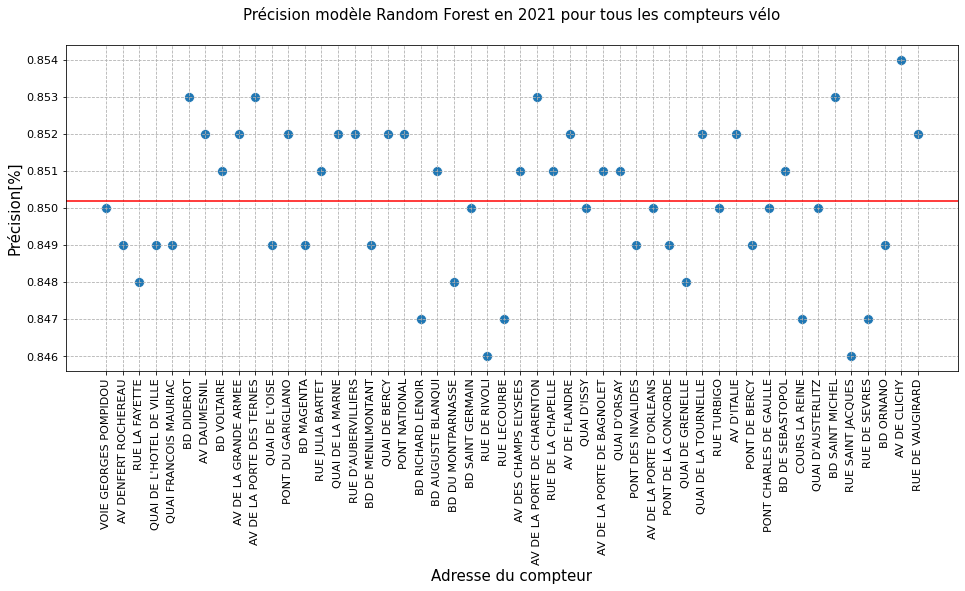

In [45]:
# 2021

# chargement des données
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

# etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

# supression des variables non essentielle pour le modèle
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal'], axis = 1)

# selection de l'année
df = df[df.Y_Date_Count == 2021 ]

# début timer
start = time.time()

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x <= 12 else 'PM' for x in df['H_Date_Count']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# passage de la variable Datetime au format date
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%dT%H:%M:%S')

# création liste contenant les scores à calculé
precision = []

# création d'un DataFrame temporaire df_t avec une selection de la fréquence en min  
for compteur in address:
    
    df_t = (df.groupby(['Address', pd.Grouper(key='Datetime', freq='120min')])
              .agg({'Count_by_hour':'sum', 
                    'Direction' : 'first', 
                    'Latitude' : 'first',
                    'Longitude' : 'first',
                    'Y_Date_Count' : 'first', 
                    'M_Date_Count' : 'first', 
                    'D_Date_Count' : 'first', 
                    'Dweek_Date_Count' : 'first',          
                    'T°C' : 'mean',
                    'Precip_last3h' : 'mean',
                    'HR%' : 'mean',
                    'High_ice' : 'mean', 
                    'Wind_speed_mean10mn' : 'mean', 'H_Date_Count' : 'first',
                    'nom_vacances' : 'first', 
                    'Confinement_id' : 'first', 
                    'week_day_type' : 'first', 
                    'AM_PM' : 'first'})).reset_index()

    # suppression de la variable Datetime
    df_t = df_t.drop('Datetime', axis = 1)

    # list des variable catégorielle
    cat_t = df_t.select_dtypes(include='object').columns.tolist()

    # Transformation des variable catégorielle en variable indicatrices
    df_t = pd.get_dummies(df_t, columns=cat_t)

    # selection de la target et des feats
    target_t = df_t['Count_by_hour']
    feats_t = df_t.drop(['Count_by_hour'], axis=1)

    target_t = pd.qcut(target_t, 4, labels = [0, 1, 2, 3])

    # Séparation du jeux de donnée pour entrainement
    X_train, X_test, y_train, y_test = train_test_split(feats_t, target_t, test_size=0.2, random_state=101)

    # preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Création d'un classifieur avec une profondeur de l'arbre = 19
    clf = ensemble.RandomForestClassifier(min_samples_split=4, max_depth = 19)
    clf.fit(X_train_scaled, y_train)
    
    # ajout des valeurs de précisions
    precision.append(clf.score(X_test, y_test).round(3))

# fin du compteur de temps
end = time.time()
print("le temps de traitement est de : ", 
      np.array((end - start) // 60).round(0), 
      "mn et", np.array(((end - start) / 60 - (end - start) // 60)*60).round(2), 
      "secondes")

# affichage des compteurs en fonction de la précision
plt.figure(figsize=(16,6))
plt.xlabel('Adresse du compteur')
plt.xticks(rotation=90)
plt.ylabel('Précision[%]')
plt.grid(linestyle='--')
plt.title('Précision modèle Random Forest en 2021 pour tous les compteurs vélo')
plt.axhline(np.array(precision).mean(), color='r')
sns.scatterplot(x=address, y=precision, s=100);

# Conclusion

La variation de précision pour le modèle Random Forest appliqué à tous les compteurs reste relativement stable et identique en fonction des années. Le Modèle Random Forest reste donc performant pour tous les compteurs de vélo à Paris.